# Project: 네이버 영화 리뷰 감성 분석

In [1]:
import pandas as pd
from konlpy.tag import Mecab
import numpy as np
from collections import Counter
import gensim
from gensim.models.keyedvectors import Word2VecKeyedVectors
import re
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import Constant
from sklearn.model_selection import train_test_split

## 1. 데이터 준비와 확인

In [2]:
import pandas as pd

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## 2. 데이터 로더 구성
- 데이터 중복 제거
- NaN 결측치 제거
- 한국어 토크나이저로 토큰화
- 불용어(Stopwords) 제거
- 사전 `word_to_index` 구성
- 텍스트 스트링을 사전 인덱스 스트링으로 변환
- `X_train`, `y_train`, `X_test`, `y_test`, `word_to_index` 리턴

In [3]:
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data = train_data.drop_duplicates(subset="document", keep="last")
    train_data = train_data.dropna(subset=["document"], axis=0)
    test_data = test_data.drop_duplicates(subset="document", keep="last")
    test_data = test_data.dropna(subset=["document"], axis=0)
    X_train = []
    for sentence in train_data.document.values:
        sentence = re.sub(r"[^ㄱ-ㅎ가-힣A-Za-z]", "", sentence) # 특수문자, 문장부호 제거하고 순수 문자만 남김
        token = tokenizer.morphs(sentence)
        token_clean = list(filter(lambda x: x not in stopwords, token))
        X_train.append(token_clean)

    X_test = []
    for sentence in test_data.document.values:
        sentence = re.sub(r"[^ㄱ-ㅎ가-힣A-Za-z]", "", sentence)
        token = tokenizer.morphs(sentence)
        token_clean = list(filter(lambda x: x not in stopwords, token))
        X_test.append(token_clean)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(num_words - 4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
    
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
    
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    y_train = train_data.label.values
    y_test = test_data.label.values
    
    return X_train, y_train, X_test, y_test, word_to_index

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [4]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [5]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

## 3. 모델 구성을 위한 데이터 분석 및 가공
- 데이터셋 내 문장 길이 분포
- 적절한 최대 문장 길이 지정
- `keras.preprocessing.sequence.pad_sequences`를 활용한 패딩 추가

In [6]:
num_tokens = [len(tokens) for tokens in X_train]
num_tokens = np.array(num_tokens)

print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

문장길이 평균 :  13.499555348811755
문장길이 최대 :  83
문장길이 표준편차 :  11.421970984953274


In [7]:
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens) # 일반적으로 정규분포에서 3 * std면 전체를 다 포함한 것으로 간주하므로 값을 이렇게 해본다.
maxlen = int(max_tokens)
print("maxlen: ", maxlen)
print(f'전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens):.4f}가 maxlen 설정값 이내에 포함됩니다.')

maxlen:  36
전체 문장의 0.9349가 maxlen 설정값 이내에 포함됩니다.


`max_tokens`의 기준은 다음 [링크](https://towardsdatascience.com/outlier-detection-part1-821d714524c)를 참고하였다. <br>
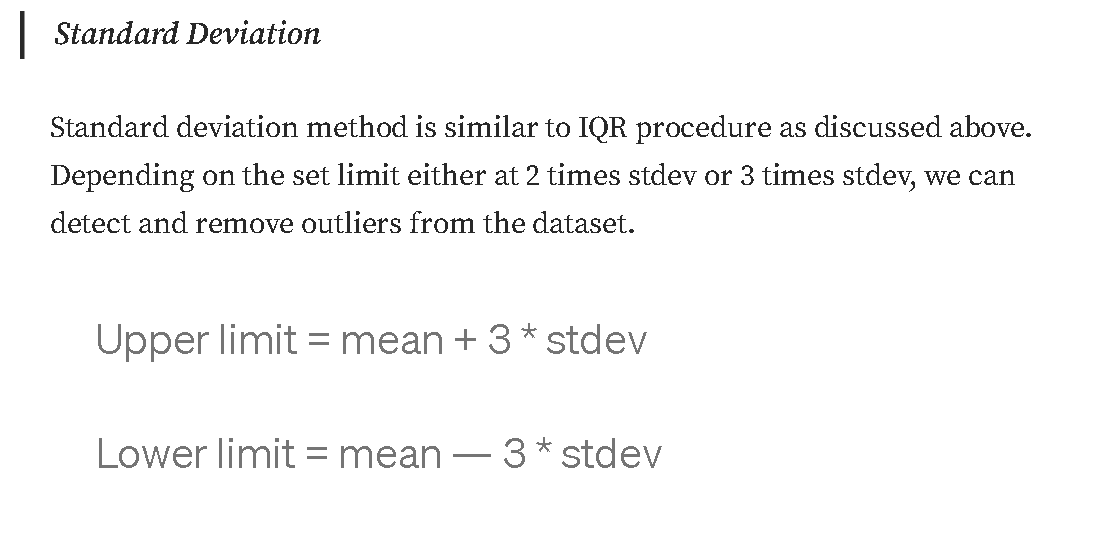

In [8]:
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre',
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre',
                                                       maxlen=maxlen)

In [9]:
print("X_train shape: ", X_train.shape)
print("X_test shape: ", X_test.shape)

X_train shape:  (146182, 36)
X_test shape:  (49157, 36)


In [10]:
# validation set 분리
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
print("X_train shape: ", X_train.shape)
print("X_valid shape: ", X_valid.shape)
print("X_test shape: ", X_test.shape)

X_train shape:  (116945, 36)
X_valid shape:  (29237, 36)
X_test shape:  (49157, 36)


## 4. 모델 구성 및 validation set 구성
- 모델 3가지 이상

In [11]:
config = {
    'vocab_size': 10000,
    'word_vector_dim': 128
}

### 1) LSTM

In [12]:
lstm = tf.keras.Sequential()
lstm.add(tf.keras.layers.Embedding(config["vocab_size"], config["word_vector_dim"], input_shape=(None,)))
lstm.add(tf.keras.layers.LSTM(8))  
lstm.add(tf.keras.layers.Dense(8, activation='relu'))
lstm.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 128)         1280000   
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 4384      
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,284,465
Trainable params: 1,284,465
Non-trainable params: 0
_________________________________________________________________


### 2) 1D-CNN

In [13]:
cnn = tf.keras.Sequential()
cnn.add(tf.keras.layers.Embedding(config["vocab_size"], config["word_vector_dim"], input_shape=(None,)))
cnn.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
cnn.add(tf.keras.layers.MaxPooling1D(5))
cnn.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
cnn.add(tf.keras.layers.GlobalMaxPooling1D())
cnn.add(tf.keras.layers.Dense(64, activation='relu'))
cnn.add(tf.keras.layers.Dense(1, activation='sigmoid'))

cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 128)         1280000   
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          14352     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                1088      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

### 3) RNN

In [14]:
rnn = tf.keras.Sequential()
rnn.add(tf.keras.layers.Embedding(config["vocab_size"], config["word_vector_dim"], input_shape=(None,)))
rnn.add(tf.keras.layers.SimpleRNN(128))  
rnn.add(tf.keras.layers.Dense(64, activation='relu'))
rnn.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

rnn.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 128)         1280000   
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 128)               32896     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 1,321,217
Trainable params: 1,321,217
Non-trainable params: 0
_________________________________________________________________


## 5. 모델 훈련 개시

In [15]:
early_stopping = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=3)

def train(model):
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    epochs = 10


    history = model.fit(X_train,
                        y_train,
                        epochs=epochs,
                        batch_size=512,
                        validation_data=(X_valid, y_valid),
                        callbacks=[early_stopping],
                        verbose=1)

    results = model.evaluate(X_test,  y_test, verbose=2)
    
    return history, results

### 1) LSTM

In [16]:
history_lstm, results_lstm = train(lstm)

Epoch 1/10
229/229 [==============================] - 5s 8ms/step - loss: 0.4629 - accuracy: 0.7993 - val_loss: 0.3784 - val_accuracy: 0.8313
Epoch 2/10
229/229 [==============================] - 1s 6ms/step - loss: 0.3449 - accuracy: 0.8508 - val_loss: 0.3661 - val_accuracy: 0.8353
Epoch 3/10
229/229 [==============================] - 1s 6ms/step - loss: 0.3174 - accuracy: 0.8641 - val_loss: 0.3644 - val_accuracy: 0.8371
Epoch 4/10
229/229 [==============================] - 1s 6ms/step - loss: 0.2968 - accuracy: 0.8735 - val_loss: 0.3657 - val_accuracy: 0.8389
Epoch 5/10
229/229 [==============================] - 1s 6ms/step - loss: 0.2770 - accuracy: 0.8841 - val_loss: 0.3753 - val_accuracy: 0.8364
Epoch 6/10
229/229 [==============================] - 1s 6ms/step - loss: 0.2568 - accuracy: 0.8931 - val_loss: 0.3839 - val_accuracy: 0.8376
Epoch 00006: early stopping
1537/1537 - 3s - loss: 0.3905 - accuracy: 0.8357


### 2) 1D-CNN

In [17]:
history_cnn, results_cnn = train(lstm)

Epoch 1/10
229/229 [==============================] - 3s 8ms/step - loss: 0.2392 - accuracy: 0.9023 - val_loss: 0.3919 - val_accuracy: 0.8373
Epoch 2/10
229/229 [==============================] - 1s 6ms/step - loss: 0.2209 - accuracy: 0.9104 - val_loss: 0.4133 - val_accuracy: 0.8359
Epoch 3/10
229/229 [==============================] - 1s 6ms/step - loss: 0.2058 - accuracy: 0.9174 - val_loss: 0.4253 - val_accuracy: 0.8352
Epoch 4/10
229/229 [==============================] - 1s 6ms/step - loss: 0.1912 - accuracy: 0.9241 - val_loss: 0.4450 - val_accuracy: 0.8323
Epoch 00004: early stopping
1537/1537 - 3s - loss: 0.4477 - accuracy: 0.8315


### 3) RNN

In [18]:
history_rnn, results_rnn = train(rnn)

Epoch 1/10
229/229 [==============================] - 10s 40ms/step - loss: 0.4419 - accuracy: 0.7844 - val_loss: 0.3709 - val_accuracy: 0.8322
Epoch 2/10
229/229 [==============================] - 9s 40ms/step - loss: 0.3245 - accuracy: 0.8605 - val_loss: 0.3861 - val_accuracy: 0.8236
Epoch 3/10
229/229 [==============================] - 9s 39ms/step - loss: 0.2468 - accuracy: 0.8983 - val_loss: 0.4187 - val_accuracy: 0.8249
Epoch 4/10
229/229 [==============================] - 9s 40ms/step - loss: 0.1767 - accuracy: 0.9301 - val_loss: 0.4921 - val_accuracy: 0.8228
Epoch 00004: early stopping
1537/1537 - 7s - loss: 0.4976 - accuracy: 0.8219


## 6. Loss, Accuracy 그래프 시각화

In [19]:
def plot(history):
    history_dict = history.history

    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    epochs = range(1, len(acc) + 1)

    # "bo"는 "파란색 점"입니다
    plt.plot(epochs, loss, 'bo', label='Training loss')
    # b는 "파란 실선"입니다
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

    plt.clf()   # 그림을 초기화합니다

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

### 1) LSTM

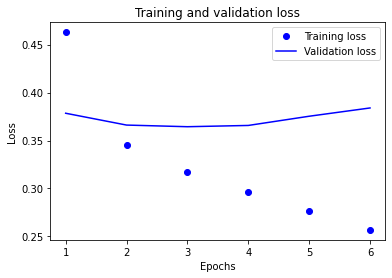

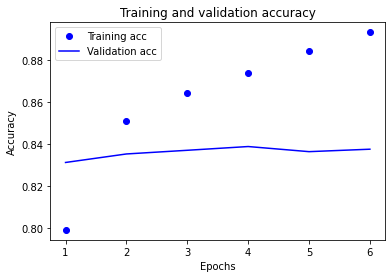

In [20]:
plot(history_lstm)

### 2) 1D-CNN

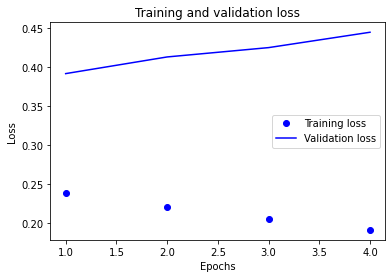

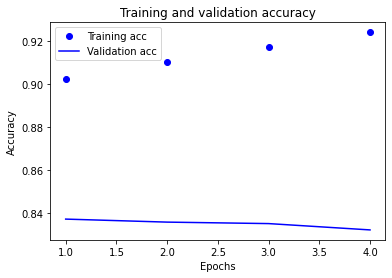

In [21]:
plot(history_cnn)

### 3) RNN

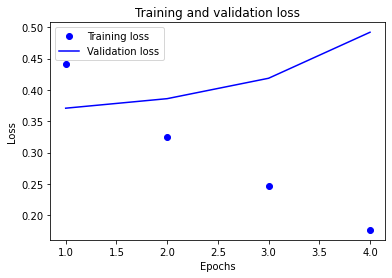

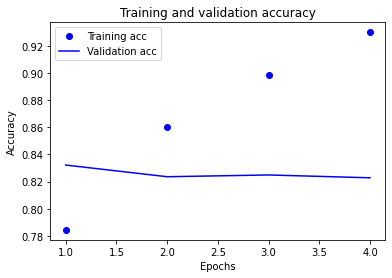

In [22]:
plot(history_rnn)

## 7. 학습된 Embedding 레이어 분석

In [23]:
class EmbeddingVectors:
    def __init__(self, model_name, config=config, index_to_word=index_to_word):
        word_vector_dim = config["word_vector_dim"]
        vocab_size = config["vocab_size"]
        word2vec_file_path = f'./data/{model_name}_word2vec.txt'
        f = open(word2vec_file_path, 'w')
        f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))
        vectors = lstm.get_weights()[0]
        for i in range(4,vocab_size):
            f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
        f.close()
        
        self.word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
    
    def get_vector(self, word):
        return self.word_vectors[word]
    
    def get_sim_word(self, word):
        return self.word_vectors.similar_by_word(word)
        

### 1) LSTM

In [24]:
lstm_vectors = EmbeddingVectors("lstm")

In [25]:
lstm_vectors.get_vector("사랑")

array([-0.09032015, -0.11591171,  0.03563363, -0.150908  ,  0.04944177,
       -0.07876353, -0.03003184, -0.07607811,  0.02394297, -0.03308475,
       -0.13448878,  0.11563107,  0.05052172, -0.0488967 , -0.04242554,
       -0.10077093,  0.00325802, -0.09043743,  0.15326132,  0.04517024,
        0.07094123, -0.07932679, -0.07441244, -0.12990294, -0.04387039,
        0.02190417, -0.0376205 ,  0.06125014, -0.13349439,  0.09672344,
        0.04976784,  0.10376678,  0.00635385,  0.03925119,  0.1438191 ,
        0.12005281, -0.07492789,  0.01848096, -0.11570597, -0.11543367,
       -0.08985272, -0.02164638,  0.03572014, -0.01258882, -0.004153  ,
       -0.05109464,  0.0085358 ,  0.11088681, -0.08995178, -0.13035637,
        0.03861919, -0.07650517,  0.10944166, -0.01639429, -0.03571844,
        0.06841788,  0.09544164, -0.08286554,  0.08612747,  0.04497212,
       -0.04579541,  0.00374681, -0.06289587,  0.03080116, -0.05383828,
        0.02753477, -0.056099  ,  0.04087882,  0.06862266,  0.03

In [26]:
lstm_vectors.get_sim_word("사랑")

[('재발견', 0.8463876843452454),
 ('개재', 0.8386300206184387),
 ('놓칠', 0.8366575837135315),
 ('첨가', 0.8361797332763672),
 ('엠마', 0.8329647183418274),
 ('사악', 0.8254464864730835),
 ('최고', 0.8248072862625122),
 ('깎아내리', 0.8225512504577637),
 ('고인', 0.8205704092979431),
 ('이제야', 0.8205412030220032)]

### 2) 1D-CNN

In [27]:
cnn_vectors = EmbeddingVectors("cnn")

In [28]:
cnn_vectors.get_vector("사랑")

array([-0.09032015, -0.11591171,  0.03563363, -0.150908  ,  0.04944177,
       -0.07876353, -0.03003184, -0.07607811,  0.02394297, -0.03308475,
       -0.13448878,  0.11563107,  0.05052172, -0.0488967 , -0.04242554,
       -0.10077093,  0.00325802, -0.09043743,  0.15326132,  0.04517024,
        0.07094123, -0.07932679, -0.07441244, -0.12990294, -0.04387039,
        0.02190417, -0.0376205 ,  0.06125014, -0.13349439,  0.09672344,
        0.04976784,  0.10376678,  0.00635385,  0.03925119,  0.1438191 ,
        0.12005281, -0.07492789,  0.01848096, -0.11570597, -0.11543367,
       -0.08985272, -0.02164638,  0.03572014, -0.01258882, -0.004153  ,
       -0.05109464,  0.0085358 ,  0.11088681, -0.08995178, -0.13035637,
        0.03861919, -0.07650517,  0.10944166, -0.01639429, -0.03571844,
        0.06841788,  0.09544164, -0.08286554,  0.08612747,  0.04497212,
       -0.04579541,  0.00374681, -0.06289587,  0.03080116, -0.05383828,
        0.02753477, -0.056099  ,  0.04087882,  0.06862266,  0.03

In [29]:
cnn_vectors.get_sim_word("사랑")

[('재발견', 0.8463876843452454),
 ('개재', 0.8386300206184387),
 ('놓칠', 0.8366575837135315),
 ('첨가', 0.8361797332763672),
 ('엠마', 0.8329647183418274),
 ('사악', 0.8254464864730835),
 ('최고', 0.8248072862625122),
 ('깎아내리', 0.8225512504577637),
 ('고인', 0.8205704092979431),
 ('이제야', 0.8205412030220032)]

### 3) RNN

In [30]:
rnn_vectors = EmbeddingVectors("rnn")

In [31]:
rnn_vectors.get_vector("사랑")

array([-0.09032015, -0.11591171,  0.03563363, -0.150908  ,  0.04944177,
       -0.07876353, -0.03003184, -0.07607811,  0.02394297, -0.03308475,
       -0.13448878,  0.11563107,  0.05052172, -0.0488967 , -0.04242554,
       -0.10077093,  0.00325802, -0.09043743,  0.15326132,  0.04517024,
        0.07094123, -0.07932679, -0.07441244, -0.12990294, -0.04387039,
        0.02190417, -0.0376205 ,  0.06125014, -0.13349439,  0.09672344,
        0.04976784,  0.10376678,  0.00635385,  0.03925119,  0.1438191 ,
        0.12005281, -0.07492789,  0.01848096, -0.11570597, -0.11543367,
       -0.08985272, -0.02164638,  0.03572014, -0.01258882, -0.004153  ,
       -0.05109464,  0.0085358 ,  0.11088681, -0.08995178, -0.13035637,
        0.03861919, -0.07650517,  0.10944166, -0.01639429, -0.03571844,
        0.06841788,  0.09544164, -0.08286554,  0.08612747,  0.04497212,
       -0.04579541,  0.00374681, -0.06289587,  0.03080116, -0.05383828,
        0.02753477, -0.056099  ,  0.04087882,  0.06862266,  0.03

In [32]:
rnn_vectors.get_sim_word("사랑")

[('재발견', 0.8463876843452454),
 ('개재', 0.8386300206184387),
 ('놓칠', 0.8366575837135315),
 ('첨가', 0.8361797332763672),
 ('엠마', 0.8329647183418274),
 ('사악', 0.8254464864730835),
 ('최고', 0.8248072862625122),
 ('깎아내리', 0.8225512504577637),
 ('고인', 0.8205704092979431),
 ('이제야', 0.8205412030220032)]

## 8. 한국어 Word2Vec 임베딩 활용하여 성능 개선

In [33]:
word2vec_file_path = "./data/word2vec_ko.model"
word2vec = gensim.models.Word2Vec.load(word2vec_file_path)
vector = word2vec.wv["사랑"]
vector

array([ 3.2565942 , -0.85421413, -3.6964011 ,  1.0956469 ,  0.599815  ,
       -1.9681435 ,  0.32379073, -1.0716053 , -1.1776937 ,  2.0442047 ,
        2.2501915 , -2.7868037 , -2.702359  , -0.9775915 , -0.12478333,
        0.28235647,  0.77683175, -1.5393747 ,  2.0879042 , -5.444462  ,
       -4.931412  ,  0.8532094 ,  0.11118065, -2.743522  ,  0.7902363 ,
        0.10469969, -0.56074625,  1.6684421 ,  1.0278419 , -3.8816829 ,
       -3.606887  , -3.120771  , -1.2527398 , -0.77196646, -1.0102901 ,
        3.331668  ,  0.30032924,  1.2074511 , -1.2813627 ,  2.6281219 ,
       -1.4624823 , -1.1354805 ,  0.7605239 ,  2.83577   , -1.199358  ,
        3.1347232 ,  4.062026  , -0.23413125,  3.205856  , -0.9567054 ,
        0.77167803, -1.4300145 ,  2.9014013 , -3.940087  , -3.234169  ,
       -5.5460634 ,  0.6185009 , -0.75793767,  2.1043491 ,  2.350599  ,
        2.9313247 , -2.235593  ,  3.2084036 , -5.594638  ,  1.6516634 ,
       -0.32628602, -1.8824683 , -1.5573231 , -1.8452163 , -1.40

In [34]:
word2vec.wv.similar_by_word("사랑")

[('이별', 0.7626414895057678),
 ('행복', 0.7550068497657776),
 ('슬픔', 0.7381505966186523),
 ('유혹', 0.7238055467605591),
 ('그리움', 0.7167419195175171),
 ('추억', 0.7143999338150024),
 ('꿈', 0.7089294195175171),
 ('애정', 0.7066588997840881),
 ('포옹', 0.7034594416618347),
 ('마음', 0.6972615718841553)]

In [35]:
vocab_size = 10000
word_vector_dim = 100
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

for i in range(4, vocab_size):
    if index_to_word[i] in word2vec.wv:
        embedding_matrix[i] = word2vec.wv[index_to_word[i]]

In [39]:
lstm_w2v = keras.Sequential()
lstm_w2v.add(keras.layers.Embedding(vocab_size,
                                 word_vector_dim,
                                 embeddings_initializer=Constant(embedding_matrix),
                                 input_length=maxlen, 
                                 trainable=True))
lstm_w2v.add(keras.layers.LSTM(128, return_sequences=True))
lstm_w2v.add(keras.layers.LSTM(128))
lstm_w2v.add(keras.layers.Dense(256, activation='relu'))
lstm_w2v.add(keras.layers.Dense(256, activation='relu'))
lstm_w2v.add(keras.layers.Dense(1, activation='sigmoid'))

lstm_w2v.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 36, 100)           1000000   
_________________________________________________________________
lstm_3 (LSTM)                (None, 36, 128)           117248    
_________________________________________________________________
lstm_4 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_8 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_9 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 257       
Total params: 1,347,905
Trainable params: 1,347,905
Non-trainable params: 0
____________________________________________

In [40]:
lstm_w2v.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [41]:
history = lstm_w2v.fit(X_train,
                    y_train,
                    epochs=5,
                    batch_size=512,
                    validation_data=(X_valid, y_valid),
                    callbacks=[early_stopping],
                    verbose=1)

results = lstm_w2v.evaluate(X_test,  y_test, verbose=2)

Epoch 1/5
229/229 [==============================] - 7s 20ms/step - loss: 0.4683 - accuracy: 0.7704 - val_loss: 0.3984 - val_accuracy: 0.8170
Epoch 2/5
229/229 [==============================] - 4s 18ms/step - loss: 0.3562 - accuracy: 0.8402 - val_loss: 0.3720 - val_accuracy: 0.8332
Epoch 3/5
229/229 [==============================] - 4s 18ms/step - loss: 0.3112 - accuracy: 0.8635 - val_loss: 0.3354 - val_accuracy: 0.8498
Epoch 4/5
229/229 [==============================] - 4s 18ms/step - loss: 0.2815 - accuracy: 0.8790 - val_loss: 0.3333 - val_accuracy: 0.8518
Epoch 5/5
229/229 [==============================] - 4s 18ms/step - loss: 0.2543 - accuracy: 0.8929 - val_loss: 0.3371 - val_accuracy: 0.8545
1537/1537 - 5s - loss: 0.3436 - accuracy: 0.8524


test 데이터로 evaluate한 결과 정확도가 `0.8524`가 나왔다.

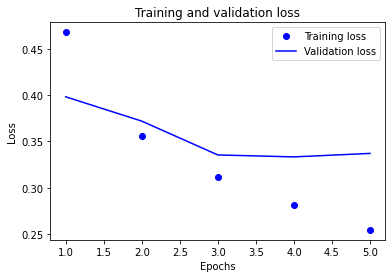

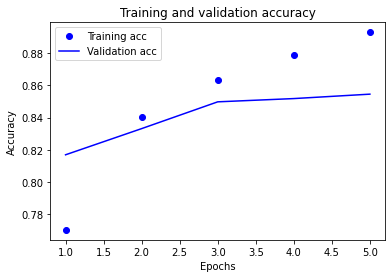

In [44]:
plot(history)

## 회고

- `max_token`을 outlier 기준으로 잡는 `std`와 곱할 상수를  2 ~ 3 사이 중 `2`, `2.5`, `3`으로 테스트해봤다. 그 결과 `2 > 2.5 > 3` 순으로 성능이 좋게 나왔다. (word2vec 적용 기준) 따라서 `std`에 `2`를 곱해주었다.

- `LSTM`, `1D-CNN`, `RNN` 중 `LSTM`이 성능이 좋게 나와서 `LSTM`에 `word2vec` 모델을 적용하였다.
- 성능을 높이기 위해 다양한 실험을 해봤다.(레이어 추가, 유닛 수 조정 등) word2vec을 사용한 모델 기준 `LSTM`을 한 층 쌓았을 때보다 두 층 쌓았을 때 성능이 더 좋게 나왔다. 또한 `Dense` 레이어도 두 층 쌓았을 때 더 성능이 향상되었다.